In [ ]:
import numpy as np
import random

n = 20


pg = [chr(65 + i) for i in range(n)] 

p_score = {p: np.random.randint(40, 100, size=6) for p in pg}
p_salary = {p: np.random.randint(5, 10) for p in pg}
p_vers = {p: np.random.randint(5, 10) for p in pg}
p_elig = {p: np.random.randint(50, 90) for p in pg}


u_score = np.random.randint(50, 100, size=6)
u_elig = np.random.randint(50, 90)

# User preferences (weights)
w_salary = 0.6
w_vers = 0.3
w_elig = 0.1  

q_dict = {program: 0 for program in pg}


lr = 0.1
gamma = 0.9
w_feed = 0.5 


episodes = 5000


for episode in range(episodes):
    
    p = random.choice(pg)
    
    similarity = np.dot(u_score, p_score[p]) / (np.linalg.norm(u_score) * np.linalg.norm(p_score[p]))

    elig_score = u_elig / p_elig[p]

    r_salary = p_salary[p] * similarity
    r_vers = p_vers[p] * similarity
    r_elig = elig_score * 10 


    reward = (w_salary * r_salary + 
              w_vers * r_vers + 
              w_elig * r_elig)


    max_q = max(q_dict.values())
    curr_q = q_dict[p]
    new_q = (1 - lr) * curr_q + lr * (reward + gamma * max_q)
    q_dict[p] = new_q

top_n = 5 
rec_p = sorted(q_dict, key=q_dict.get, reverse=True)[:top_n]

print("Top recommended programs")
for i, p in enumerate(rec_p, 1):
    print(f"{i}. Program {p}")




In [ ]:
u_feed = {}
for p in rec_p:
    while True:
        try:
            score = int(input(f"Rate Program {p} (0-5): "))
            if 0 <= score <= 5:
                u_feed[p] = score
                break
            else:
                print("Please enter a valid score between 0 and 5.")
        except ValueError:
            print("Please enter a valid integer.")


In [ ]:
# Adjust Q-values based on user feedback
for p, score in u_feed.items():
    if score == 0:
        # Strong disagreement: Heavily penalize the Q-value
        q_dict[p] -= w_feed * 10
    else:
        # Adjust Q-value based on the user's score (higher score = higher preference)
        q_dict[p] += w_feed * score

# Recommend the top N programs again after incorporating user feedback
revised = sorted(q_dict, key=q_dict.get, reverse=True)[:top_n]

print("\nTop recommended programs after incorporating user feedback:")
for i, p in enumerate(revised, 1):
    print(f"{i}. Program {p}")

In [ ]:
import numpy as np
import random

# Initialize program details
n_p = 20
progs = [chr(65 + i) for i in range(n_p)]
p_s = {p: np.random.randint(40, 100, size=6) for p in progs}
p_sal = {p: np.random.randint(5, 10) for p in progs}
p_vers = {p: np.random.randint(5, 10) for p in progs}
p_elg = {p: np.random.randint(50, 90) for p in progs}


u_s = np.random.randint(50, 100, size=6).astype(float)
u_elg = float(np.random.randint(50, 90))  
w_sal = 0.6
w_vers = 0.3
w_elg = 0.1

q_vals = {p: 0.0 for p in progs}
lr = 0.1
gamma = 0.9
f_adj = 0.5
epsilon_threshold = 0.01
top_n = 5


questions_pool = np.random.rand(1000)
asked_questions = []

def ask_qs():
    global asked_questions, u_s
    selected_questions = random.sample(list(questions_pool), 6)
    for weight in selected_questions:
        answer = int(input(f"Answer question (0-5): "))
        answer = max(0, min(answer, 5)) 
        u_s += answer * weight  
    asked_questions.extend(selected_questions)
    return u_s

def update_q_vals():
    epsilon = 0
    for p in progs:
        sim = np.dot(u_s, p_s[p]) / (np.linalg.norm(u_s) * np.linalg.norm(p_s[p]))
        elg_impact = u_elg / p_elg[p]
        r_sal = p_sal[p] * sim
        r_vers = p_vers[p] * sim
        r_elg = elg_impact * 10
        reward = w_sal * r_sal + w_vers * r_vers + w_elg * r_elg
        max_q = max(q_vals.values())
        old_q = q_vals[p]
        q_vals[p] = (1 - lr) * q_vals[p] + lr * (reward + gamma * max_q)
        
    return q_vals, old_q

def get_feedback(rec):
    global progs
    fb = {p: int(input(f"Rate {p} (0-5): ")) for p in rec}
    for p, score in fb.items():
        if score == 0:
            progs.remove(p)
            del q_vals[p]
        else:
            q_vals[p] += f_adj * (score - 2) * 5

max_ep = 10
for ep in range(max_ep):
    u_s = ask_qs()
    q_vals, old_q = update_q_vals()
    epsilon=abs(q_vals-old_q)
    print(q_vals, old_q)
    if len(progs) < top_n:
        break
    
    if epsilon < epsilon_threshold:
        rec = sorted(q_vals, key=q_vals.get, reverse=True)[:top_n]
        get_feedback(rec)
        satisfied = input("Satisfied? (yes/no): ").strip().lower()

        if satisfied == 'yes':
            break

if len(progs) >= top_n:
    print("\nFinal Recommendations:")
    rec = sorted(q_vals, key=q_vals.get, reverse=True)[:top_n]
    for i, p in enumerate(rec, 1):
        print(f"{i}. {p}")
else:
    print("\nNot enough programs left to recommend. Test ends.")


In [ ]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc2_mean = nn.Linear(400, latent_dim)
        self.fc2_logvar = nn.Linear(400, latent_dim)
        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc2_mean(h1), self.fc2_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar




class Generator(nn.Module):
    def __init__(self, z_dim=20, img_dim=784):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, img_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, img_dim=784):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [22]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set up the dataset and data loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

from torchvision import datasets, transforms

# Update transform to scale values to [0, 1] instead of using normalization
transform = transforms.Compose([
    transforms.ToTensor()  # Automatically scales pixel values to [0, 1]
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)


In [25]:
import torch.optim as optim

# Initialize the VAE model, optimizer, and loss function
vae = VAE(latent_dim=20)
vae_optimizer = optim.Adam(vae.parameters(), lr=1e-3)

def vae_loss(reconstructed_x, x, mu, logvar):
    # Ensure x and reconstructed_x are of type float
    x = x.float()
    reconstructed_x = reconstructed_x.float()
    
    # Binary Cross Entropy for Reconstruction Loss
    recon_loss = nn.functional.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    
    # KL Divergence for Latent Space Regularization
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_divergence


# Training loop for VAE
num_epochs = 10
for epoch in range(num_epochs):
    vae.train()
    total_loss = 0
    for x, _ in train_loader:
        x = x.view(-1, 784)
        x = (x + 1) / 2 # Flatten images to 784 dimensions
        reconstructed, mu, logvar = vae(x)
        loss = vae_loss(reconstructed, x, mu, logvar)
        
        vae_optimizer.zero_grad()
        loss.backward()
        vae_optimizer.step()
        
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], VAE Loss: {total_loss / len(train_loader.dataset):.4f}")


Epoch [1/10], VAE Loss: 274.3880
Epoch [2/10], VAE Loss: 251.8692
Epoch [3/10], VAE Loss: 247.6387
Epoch [4/10], VAE Loss: 245.6685
Epoch [5/10], VAE Loss: 244.5553
Epoch [6/10], VAE Loss: 243.6389
Epoch [7/10], VAE Loss: 243.0937
Epoch [8/10], VAE Loss: 242.5232
Epoch [9/10], VAE Loss: 242.0979
Epoch [10/10], VAE Loss: 241.7394


In [26]:
# Initialize the GAN models, optimizers, and loss function
generator = Generator(z_dim=20, img_dim=784)
discriminator = Discriminator(img_dim=784)
gen_optimizer = optim.Adam(generator.parameters(), lr=2e-4)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4)
criterion = nn.BCELoss()

# Training loop for GAN
for epoch in range(num_epochs):
    for real, _ in train_loader:
        real = real.view(-1, 784)  # Flatten images to 784 dimensions
        batch_size = real.size(0)
        
        # Labels
        labels_real = torch.ones(batch_size, 1)
        labels_fake = torch.zeros(batch_size, 1)

        # Train Discriminator
        noise = torch.randn(batch_size, 20)  # Latent dimension is 20
        fake = generator(noise)
        
        disc_real = discriminator(real)
        disc_fake = discriminator(fake.detach())
        loss_disc = criterion(disc_real, labels_real) + criterion(disc_fake, labels_fake)
        
        disc_optimizer.zero_grad()
        loss_disc.backward()
        disc_optimizer.step()

        # Train Generator
        output = discriminator(fake)
        loss_gen = criterion(output, labels_real)
        
        gen_optimizer.zero_grad()
        loss_gen.backward()
        gen_optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Disc Loss: {loss_disc:.4f}, Gen Loss: {loss_gen:.4f}")


Epoch [1/10], Disc Loss: 0.0824, Gen Loss: 4.8804
Epoch [2/10], Disc Loss: 0.0151, Gen Loss: 5.6423
Epoch [3/10], Disc Loss: 0.0283, Gen Loss: 4.3698
Epoch [4/10], Disc Loss: 0.1124, Gen Loss: 4.6074
Epoch [5/10], Disc Loss: 0.5203, Gen Loss: 4.0036
Epoch [6/10], Disc Loss: 0.2749, Gen Loss: 3.3562
Epoch [7/10], Disc Loss: 0.2744, Gen Loss: 3.9777
Epoch [8/10], Disc Loss: 0.2466, Gen Loss: 4.2355
Epoch [9/10], Disc Loss: 0.3188, Gen Loss: 3.7821
Epoch [10/10], Disc Loss: 0.2675, Gen Loss: 3.1697


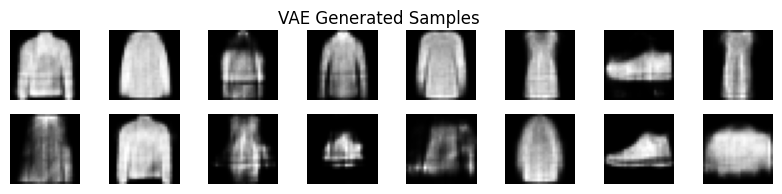

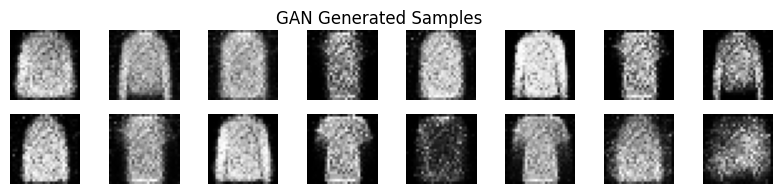

In [31]:
import matplotlib.pyplot as plt

# Generate VAE samples
with torch.no_grad():
    z = torch.randn(16, 20)  # Sample from Gaussian
    vae_generated_images = vae.decode(z).view(-1, 28, 28).numpy()

# Generate GAN samples
with torch.no_grad():
    z = torch.randn(16, 20)
    gan_generated_images = generator(z).view(-1, 28, 28).numpy()

# Plot VAE generated images
fig, axes = plt.subplots(2, 8, figsize=(10, 2))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(vae_generated_images[i], cmap='gray')
    ax.axis('off')
plt.suptitle("VAE Generated Samples")
plt.show()

# Plot GAN generated images
fig, axes = plt.subplots(2, 8, figsize=(10, 2))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(gan_generated_images[i], cmap='gray')
    ax.axis('off')
plt.suptitle("GAN Generated Samples")
plt.show()


In [2]:
from NewIRT import AdaptiveMIRTv2
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
model = AdaptiveMIRTv2(select_noise=0.1, n_items=10000, n_traits=6, verbose=False)

In [ ]:
model.binary_items

2033

In [ ]:


# Initialize AdaptiveMIRTv2 with 10,000 items


# Number of adaptive steps
n_steps = 100

# Track time for each iteration
iteration_times = []

# Run adaptive testing with tqdm progress bar
for _ in tqdm(range(n_steps), desc="Running Adaptive Testing"):
    start_time = time.time()
    
    # Select the next item and simulate a response
    model.next_item()
    model.simulate_response()
    
    # Update theta estimates
    model.update_theta()
    
    # Record the time for this iteration
    iteration_times.append(time.time() - start_time)



Running Adaptive Testing:   0%|          | 0/100 [00:00<?, ?it/s]


AttributeError: 'AdaptiveMIRTv2' object has no attribute 'binary_items'

In [ ]:
import numpy as np

# Setup
n_items = 1000
probs = [0.4, 0.2, 0.2, 0.1, 0.1]
item_opts = ['likert', 'binary', 'value', 'mc_single', 'mc_multi']
item_types = np.random.choice(item_opts, size=n_items, p=probs)

# Subset of indices
x = np.random.randint(0, n_items, size=100)

# Dictionary to store the subset of x for each type
subset_x_by_type = {}

# Find the subset of x for each type


# Display the subset for each type
print("Subset of x by type:", subset_x_by_type)


Subset of x by type: {'likert': array([428, 225, 238,  15, 779, 572, 159, 345, 899, 756, 481, 312, 894,
       247, 392, 925, 999, 325, 315, 247, 600, 775, 126, 677, 225, 760,
       715, 671, 157, 198, 440, 323, 640, 711, 215, 144, 570]), 'binary': array([573, 543, 964, 236, 907, 444, 791,  76, 813, 141, 793, 370, 710,
       972,   8, 850, 701, 449, 246, 896, 611,  98]), 'value': array([615, 109, 703, 158, 293, 821, 609,  17, 721,  66, 631,  69, 112,
        69, 717, 533, 188, 990,  60, 596]), 'mc_single': array([395, 287, 165, 646, 591, 607,  39,  40, 530, 497, 421, 725, 174]), 'mc_multi': array([746, 363, 962, 234, 804, 537, 363, 401])}


In [28]:
%%timeit
for item_type in item_opts:
    # Get indices in x where item_types is equal to item_type
    subset_x = x[item_types[x] == item_type]
    subset_x_by_type[item_type] = subset_x

16.4 µs ± 682 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [31]:
%%timeit
subset_xs = [x[item_types[x] == item_opts[q]] for q in range(len(item_opts))]

16.5 µs ± 317 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [41]:
a_params = np.random.randn(n_items, 6)
bin_b = np.random.randn(n_items)
theta0 = np.random.uniform(-3, 3, size=6)

In [45]:
from scipy.special import expit
def bin_prob(a, b, theta):
    return expit(a @ theta - b)

In [69]:
resp = np.random.binomial(1, prob_list)
resp

array([1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0])

In [76]:
%%timeit
probs = []
ll = 0
resps = []
for i in subset_xs[0]:
    prob = bin_prob(a_params[i], bin_b[i], theta0)
    prob = np.clip(prob, 1e-8, 1 - 1e-8)
    probs.append(prob)
    resp = np.random.binomial(1, prob)
    resps.append(resp)
    ll += resp * np.log(prob) + (1-resp) * np.log(1-prob)   

251 µs ± 5.46 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [78]:
%%timeit
p = np.clip(bin_prob(a_params[subset_xs[0]], bin_b[subset_xs[0]], theta0), 1e-8, 1 - 1e-8)
r = np.random.binomial(1, p)
nll = 0
nll = np.sum(r*np.log(p) + (1-r)*np.log(1-p))

26.8 µs ± 452 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [75]:
nll==ll

True

In [62]:
%%timeit
prob_list = np.clip(bin_prob(a_params[subset_xs[0]], bin_b[subset_xs[0]], theta0), 1e-8, 1 - 1e-8)

8.44 µs ± 161 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
resp_list = 

array([9.94096901e-01, 5.05655451e-01, 4.46317992e-01, 9.90507313e-01,
       1.01833843e-01, 5.70116750e-01, 9.95461607e-01, 5.79087961e-01,
       9.93910803e-01, 7.51105290e-02, 8.41407350e-01, 9.08090574e-01,
       9.98700842e-01, 1.67690110e-01, 4.83874247e-03, 3.45870644e-01,
       2.88236725e-01, 9.99732884e-01, 2.44999507e-01, 1.67690110e-01,
       2.32957158e-02, 2.74919187e-01, 7.40505656e-01, 2.88807150e-02,
       5.05655451e-01, 9.85373691e-01, 5.79135338e-01, 7.31579191e-04,
       3.66965022e-05, 4.42579730e-01, 9.99940747e-01, 3.26355511e-02,
       5.73346006e-03, 4.99576552e-01, 8.41561617e-01, 9.99992496e-01,
       2.02732524e-02])

In [13]:
# Sampling from GAN latent space after training
with torch.no_grad():
    z = torch.randn(16, 20)  # Latent space dimension is 20
    gan_generated_images = generator(z).view(-1, 28, 28).numpy()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x20 and 100x128)